In [8]:
from qiskit import QuantumCircuit 

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.circuit.library import GroverOperator,Diagonal

from qiskit.quantum_info import Statevector 
from qiskit.visualization import plot_histogram,plot_distribution

from qiskit_ibm_runtime import QiskitRuntimeService,Batch,SamplerV2 as Sampler

In [9]:
service=QiskitRuntimeService()

backend=service.least_busy(operational=True,simulator=False)

backend.name

'ibm_brisbane'

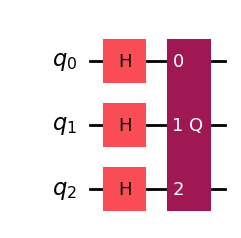

In [6]:
oracle=Diagonal([1]*7+[-1])
qc=QuantumCircuit(3)
qc.h([0,1,2])
qc=qc.compose(GroverOperator(oracle))

qc.draw(output="mpl")

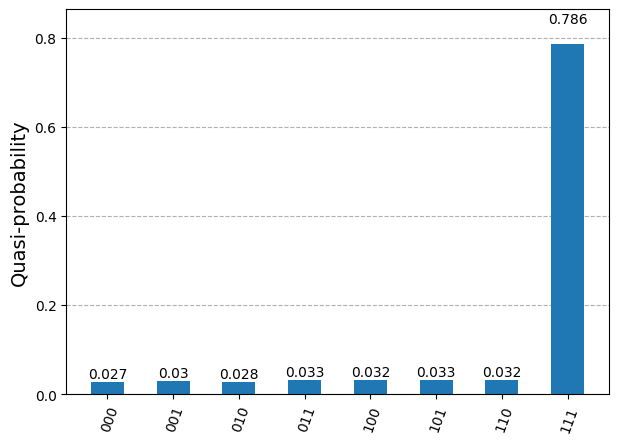

In [18]:
from qiskit_aer import QasmSimulator
from qiskit import transpile
backend_sim=QasmSimulator()

transpiled_circ=transpile(qc,backend_sim)
pub=backend_sim.run(transpiled_circ,shots=4000)

result=pub.result()
counts_ideal=result.get_counts()

plot_distribution(counts_ideal)

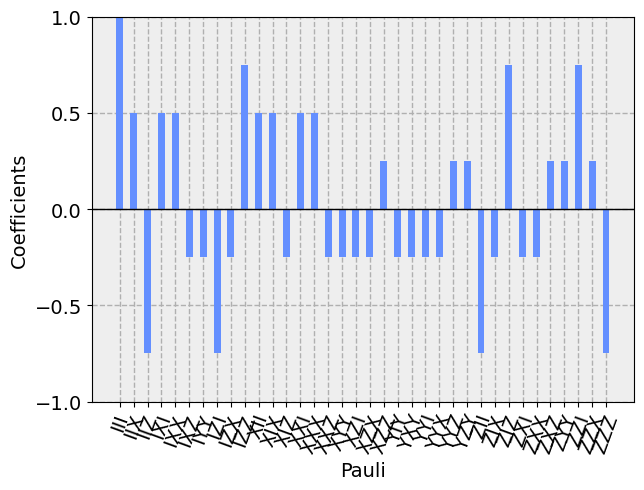

In [7]:
ideal=Statevector.from_instruction(qc)

ideal.draw(output="paulivec")

In [8]:
from qiskit.quantum_info import DensityMatrix 

DM=DensityMatrix.from_instruction(qc)

DM.draw(output="latex")

<IPython.core.display.Latex object>

In [9]:
qc.measure_all()

twoQ_gate=set(["ecr","cz","cx"])
for gate in backend.basis_gates:
    if gate in twoQ_gate:
        twoQ_gate=gate 
circuits=[]

for optimization_level in [0,3]:
    pm=generate_preset_pass_manager(optimization_level,backend=backend,seed_transpiler=0)
    t_qc=pm.run(qc)
    print(f"Two-qubit gates (optimization_level={optimization_level}): ", t_qc.count_ops()[twoQ_gate])
    circuits.append(t_qc)

Two-qubit gates (optimization_level=0):  21
Two-qubit gates (optimization_level=3):  14


In [10]:
from qiskit.transpiler import PassManager 
from qiskit_ibm_runtime.transpiler.passes.scheduling import(
    ASAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.library import XGate

In [11]:
durations=backend.target.durations()
dd_sequence=[XGate(),XGate()]

pm=PassManager(
    [ASAPScheduleAnalysis(durations),
     PadDynamicalDecoupling(durations,dd_sequence)]
)
circ_dd=pm.run(circuits[1])
circuits.append(circ_dd)

In [20]:
print(f"Target Durations:\n {durations}")

Target Durations:
 x(0,): 6e-08 s
x(1,): 6e-08 s
x(2,): 6e-08 s
x(3,): 6e-08 s
x(4,): 6e-08 s
x(5,): 6e-08 s
x(6,): 6e-08 s
x(7,): 6e-08 s
x(8,): 6e-08 s
x(9,): 6e-08 s
x(10,): 6e-08 s
x(11,): 6e-08 s
x(12,): 6e-08 s
x(13,): 6e-08 s
x(14,): 6e-08 s
x(15,): 6e-08 s
x(16,): 6e-08 s
x(17,): 6e-08 s
x(18,): 6e-08 s
x(19,): 6e-08 s
x(20,): 6e-08 s
x(21,): 6e-08 s
x(22,): 6e-08 s
x(23,): 6e-08 s
x(24,): 6e-08 s
x(25,): 6e-08 s
x(26,): 6e-08 s
x(27,): 6e-08 s
x(28,): 6e-08 s
x(29,): 6e-08 s
x(30,): 6e-08 s
x(31,): 6e-08 s
x(32,): 6e-08 s
x(33,): 6e-08 s
x(34,): 6e-08 s
x(35,): 6e-08 s
x(36,): 6e-08 s
x(37,): 6e-08 s
x(38,): 6e-08 s
x(39,): 6e-08 s
x(40,): 6e-08 s
x(41,): 6e-08 s
x(42,): 6e-08 s
x(43,): 6e-08 s
x(44,): 6e-08 s
x(45,): 6e-08 s
x(46,): 6e-08 s
x(47,): 6e-08 s
x(48,): 6e-08 s
x(49,): 6e-08 s
x(50,): 6e-08 s
x(51,): 6e-08 s
x(52,): 6e-08 s
x(53,): 6e-08 s
x(54,): 6e-08 s
x(55,): 6e-08 s
x(56,): 6e-08 s
x(57,): 6e-08 s
x(58,): 6e-08 s
x(59,): 6e-08 s
x(60,): 6e-08 s
x(61,): 6e-08 s

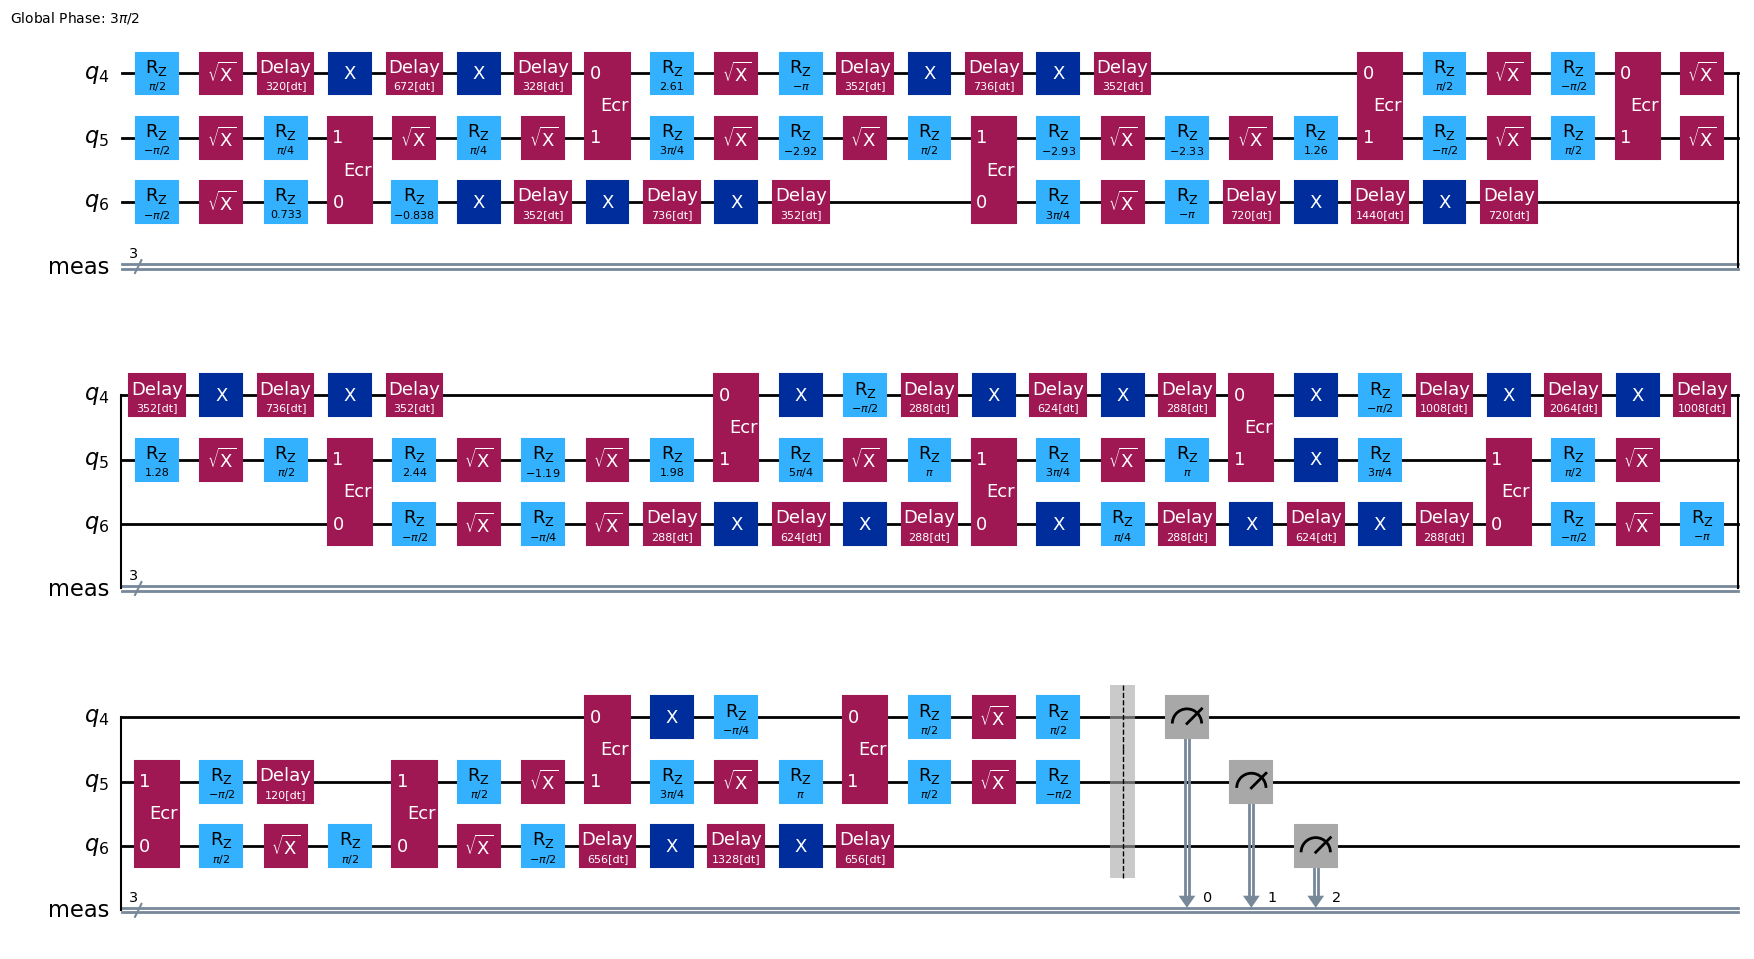

In [13]:
circ_dd.draw(output="mpl",idle_wires=False)

In [ ]:
with Batch(backend=backend):
    sampler=Sampler(mode=backend)
    job=sampler.run(
        [(circuit) for circuit in circuits],
        shots=8000
    )
    result=job.result()

In [14]:
job = service.job('cvvgpv37cb40008e6npg')
job_result = job.result()

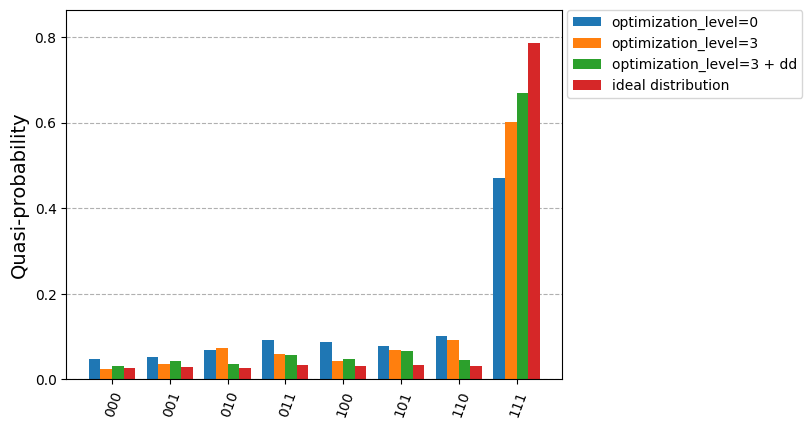

In [19]:
binary_prob = [{k: v / res.data.meas.num_shots for k, v in res.data.meas.get_counts().items()} for res in job_result]
plot_histogram(
    binary_prob + [counts_ideal],
    bar_labels=False,
    legend=[
        "optimization_level=0",
        "optimization_level=3",
        "optimization_level=3 + dd",
        "ideal distribution",
    ],
)

In [1]:
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts

In [10]:
def count_ops(qc):
    print(f"Counting number of operations:\n\n")
    for i,j in qc.count_ops().items():
      print(f"{i} : {j}")

In [11]:
num_qubits = 5
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=num_qubits)
backend.name

'ibm_brisbane'

In [12]:
qreg_data = QuantumRegister(3)
qreg_measure = QuantumRegister(2)
creg_data = ClassicalRegister(3, name="data")
creg_syndrome = ClassicalRegister(2, name="syndrome")
state_data = qreg_data[0]
ancillas_data = qreg_data[1:]

def build_qc():
    """Build a typical error correction circuit"""
    return QuantumCircuit(qreg_data, qreg_measure, creg_data, creg_syndrome)

def initialize_qubits(circuit: QuantumCircuit):
    """Initialize qubit to |1>"""
    circuit.x(qreg_data[0])
    circuit.barrier(qreg_data)
    return circuit

def encode_bit_flip(circuit, state, ancillas) -> QuantumCircuit:
    """Encode bit-flip. This is done by simply adding a cx"""
    for ancilla in ancillas:
        circuit.cx(state, ancilla)
    circuit.barrier(state, *ancillas)
    return circuit

def measure_syndrome_bit(circuit, qreg_data, qreg_measure, creg_measure):
    """
        Measure the syndrome by measuring the parity.
        We reset our ancilla qubits after measuring the stabilizer
        so we can reuse them for repeated stabilizer measurements.
        Because we have already observed the state of the qubit,
        we can write the conditional reset protocol directly to
        avoid another round of qubit measurement if we used
        the `reset` instruction.
    """
    circuit.cx(qreg_data[0], qreg_measure[0])
    circuit.cx(qreg_data[1], qreg_measure[0])
    circuit.cx(qreg_data[0], qreg_measure[1])
    circuit.cx(qreg_data[2], qreg_measure[1])
    circuit.barrier(*qreg_data, *qreg_measure)
    circuit.measure(qreg_measure, creg_measure)
    with circuit.if_test((creg_syndrome[0], 1)):
        circuit.x(qreg_measure[0])
    with circuit.if_test((creg_syndrome[1], 1)):
        circuit.x(qreg_measure[1])
    circuit.barrier(*qreg_data, *qreg_measure)
    return circuit

def apply_correction_bit(circuit, qreg_data, creg_syndrome):
    """We can detect where an error occurred and correct our state"""
    with circuit.if_test((creg_syndrome, 3)):
        circuit.x(qreg_data[0])
    with circuit.if_test((creg_syndrome, 1)):
        circuit.x(qreg_data[1])
    with circuit.if_test((creg_syndrome, 2)):
        circuit.x(qreg_data[2])
    circuit.barrier(qreg_data)
    return circuit

def apply_final_readout(circuit, qreg_data, creg_data):
    """Read out the final measurements"""
    circuit.barrier(qreg_data)
    circuit.measure(qreg_data, creg_data)
    return circuit

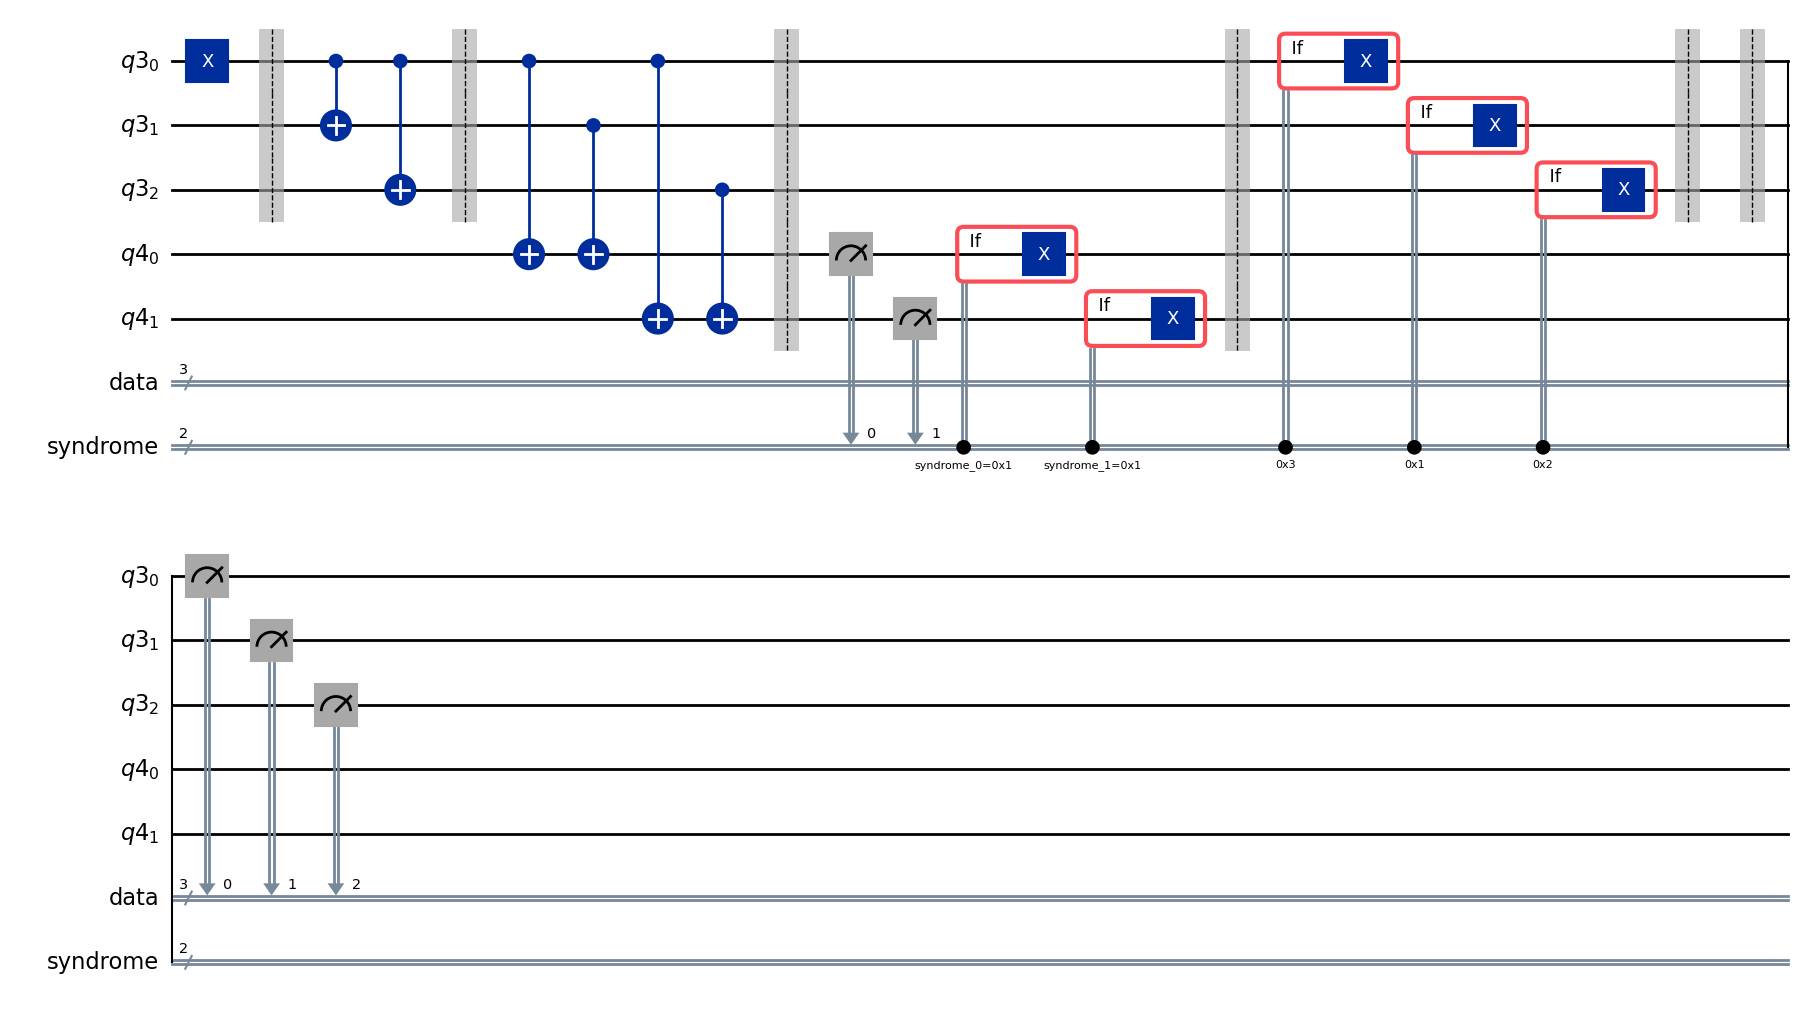

In [13]:
def build_error_correction_sequence(apply_correction: bool) -> QuantumCircuit:

    circuit = build_qc()
    circuit = initialize_qubits(circuit)
    circuit = encode_bit_flip(circuit, state_data, ancillas_data)
    circuit = measure_syndrome_bit(circuit, qreg_data, qreg_measure, creg_syndrome)

    if apply_correction:
        circuit = apply_correction_bit(circuit, qreg_data, creg_syndrome)

    circuit = apply_final_readout(circuit,  qreg_data, creg_data)
    return circuit

circuit = build_error_correction_sequence(apply_correction=True)
circuit.draw(output="mpl", style='iqp')

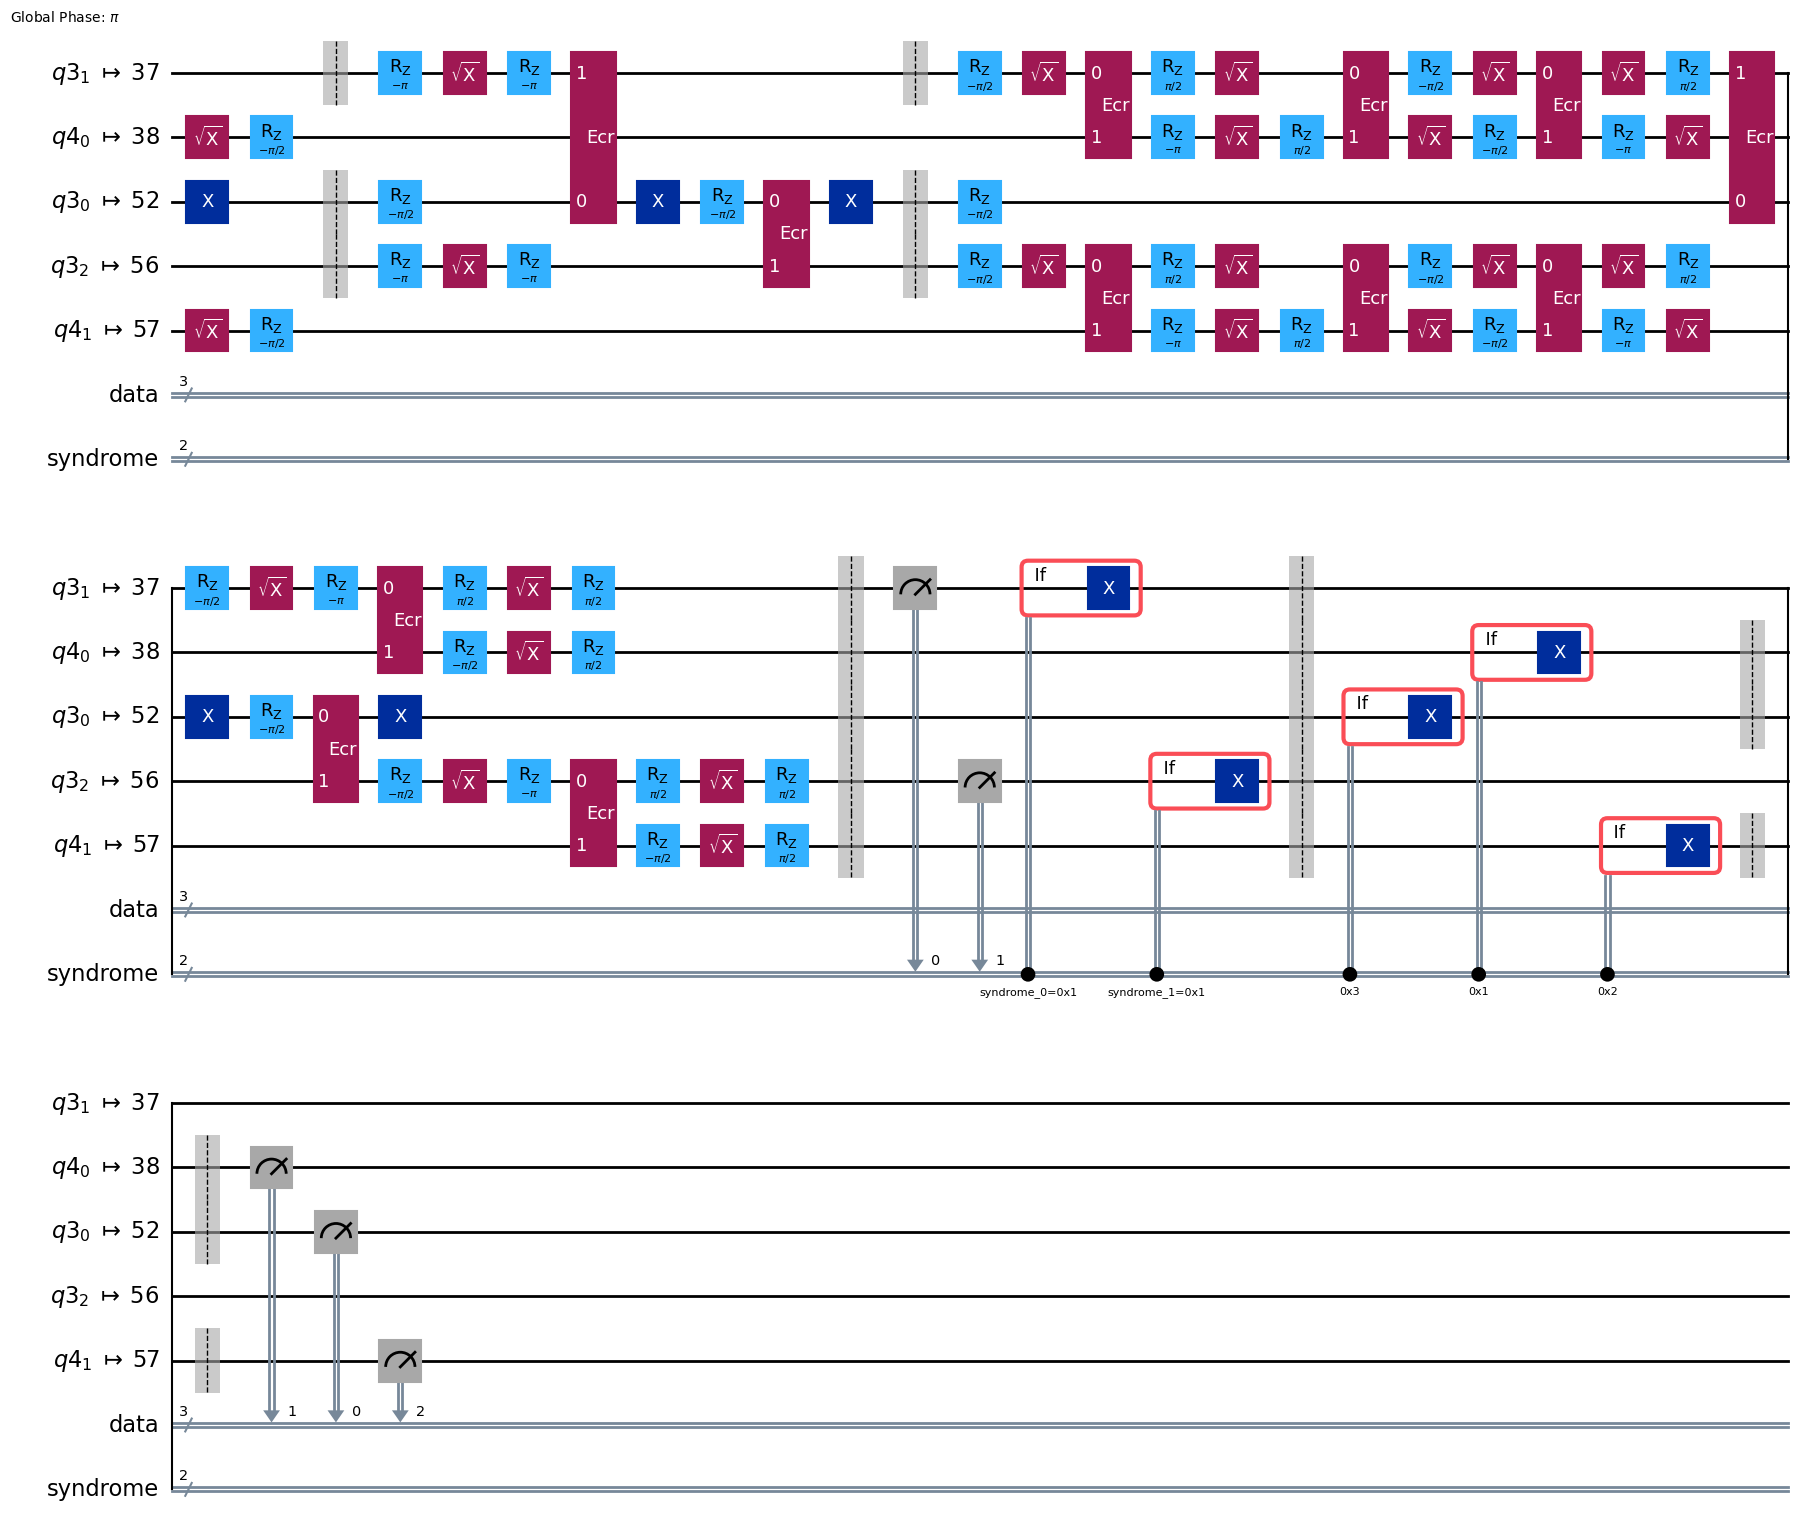

In [14]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

isa_circuit.draw('mpl', style='iqp', idle_wires=False)

In [15]:
print("Comparing Circuit Depth for Correction Circuit: ")
print(f"Initial Circuit Depth: {circuit.depth()}")
print(f"ISA Circuit Depth: {isa_circuit.depth()}\n\n")

count_ops(isa_circuit)


Comparing Circuit Depth for Correction Circuit: 
Initial Circuit Depth: 12
ISA Circuit Depth: 38


Counting number of operations:


rz : 38
sx : 24
ecr : 12
barrier : 6
x : 5
measure : 5
if_else : 5


In [16]:
no_correction=build_error_correction_sequence(apply_correction=False)
isa_no_correction=pm.run(no_correction)

print("Comparing Circuit Depth for No-Correction Circuit: ")
print(f"Initial Circuit Depth: {no_correction.depth()}")
print(f"ISA Circuit Depth: {isa_no_correction.depth()}\n")



Comparing Circuit Depth for No-Correction Circuit: 
Initial Circuit Depth: 9
ISA Circuit Depth: 35



In [46]:
count_ops(isa_no_correction)

Counting number of operations:


rz : 38
sx : 24
ecr : 12
x : 5
barrier : 5
measure : 5
if_else : 2


In [49]:
sampler_no_correction=Sampler(backend)
job_no_correction=sampler_no_correction.run([isa_no_correction],shots=1000)

print(f"Job id with no correction: {job_no_correction.job_id()}")
result_no_correction=job_no_correction.result()[0]


Job id with no correction: cvvh3jybtzcg008n0wqg


In [17]:
sampler_with_correction=Sampler(backend)
job_with_correction=sampler_with_correction.run([isa_circuit],shots=1000)

print(f"Job id with QEC: {job_with_correction.job_id()}")



      

Job id with QEC: cvvh5rf5sat0008hy3s0


In [ ]:
def decode_result(data_counts, syndrome_counts):
    shots = sum(data_counts.values())
    success_trials = data_counts.get('000', 0) + data_counts.get('111', 0)
    failed_trials = shots - success_trials
    error_correction_events = shots - syndrome_counts.get('00', 0)
    print(f"Bit flip errors were detected/corrected on {error_correction_events}/{shots} trials.")
    print(f"A final parity error was detected on {failed_trials}/{shots} trials.")

In [ ]:
# non-corrected marginalized results
data_result = result_corrected.data.data.get_counts()
marginalized_syndrome_result = result_corrected.data.syndrome.get_counts()

print(f'Completed bit code experiment data measurement counts (no correction): {data_result}')
print(f'Completed bit code experiment syndrome measurement counts (no correction): {marginalized_syndrome_result}')
decode_result(data_result, marginalized_syndrome_result)

In [ ]:
# corrected marginalized results
corrected_data_result = result_with_correction.data.data.get_counts()
corrected_syndrome_result = result_with_correction.data.syndrome.get_counts()

print(f'Completed bit code experiment data measurement counts (corrected): {corrected_data_result}')
print(f'Completed bit code experiment syndrome measurement counts (corrected): {corrected_syndrome_result}')
decode_result(corrected_data_result, corrected_syndrome_result)